In [37]:
# 1. Data Ingestion
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Define file path
data_path = 'final_adjusted_crowd_dataset.csv'

# Load the dataset
df = pd.read_csv(data_path)
print(df.head())

   Longitude   Latitude  Speed  Distance      Time     Acc X     Acc Y  \
0  73.822661  18.501627    0.0       0.0  18-45-12  0.046402 -0.137178   
1  73.822661  18.501627    0.0       0.0  18-45-12 -0.136978  0.365242   
2  73.822661  18.501627    0.0       0.0  18-45-13 -0.045355 -0.103340   
3  73.822661  18.501627    0.0       0.0  18-45-13  0.242089  0.072761   
4  73.822661  18.501627    0.0       0.0  18-45-13 -0.230234  0.011765   

      Acc Z  Heading    gyro_x    gyro_y    gyro_z  label  
0 -0.282934      352 -0.036306 -0.008226 -0.023416      0  
1  0.108889      352  0.035776 -0.009448  0.009570      0  
2 -0.534985      352 -0.011871 -0.027774  0.003462      0  
3 -0.350396      352 -0.017980  0.002769 -0.005091      0  
4 -0.494085      352  0.011342  0.003380  0.006516      0  


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14249 entries, 0 to 14248
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Longitude  14249 non-null  float64
 1   Latitude   14249 non-null  float64
 2   Speed      14249 non-null  float64
 3   Distance   14249 non-null  float64
 4   Time       14249 non-null  object 
 5   Acc X      14249 non-null  float64
 6   Acc Y      14249 non-null  float64
 7   Acc Z      14249 non-null  float64
 8   Heading    14249 non-null  int64  
 9   gyro_x     14249 non-null  float64
 10  gyro_y     14249 non-null  float64
 11  gyro_z     14249 non-null  float64
 12  label      14249 non-null  int64  
dtypes: float64(10), int64(2), object(1)
memory usage: 1.4+ MB
None

Missing Values Count:
Longitude    0
Latitude     0
Speed        0
Distance     0
Time         0
Acc X        0
Acc Y        0
Acc Z        0
Heading      0
gyro_x       0
gyro_y       0
gyro_z       0

<ipython-input-38-6295f74f428f>:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


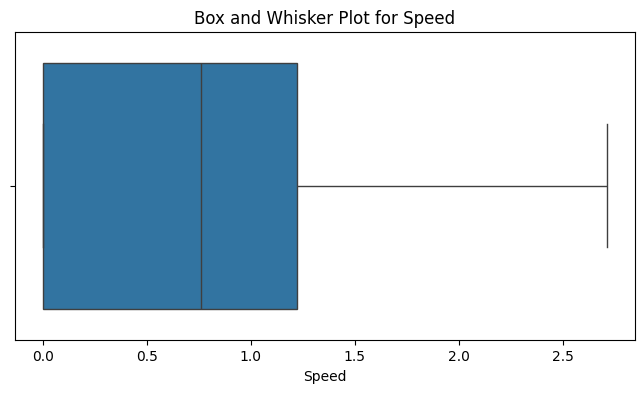

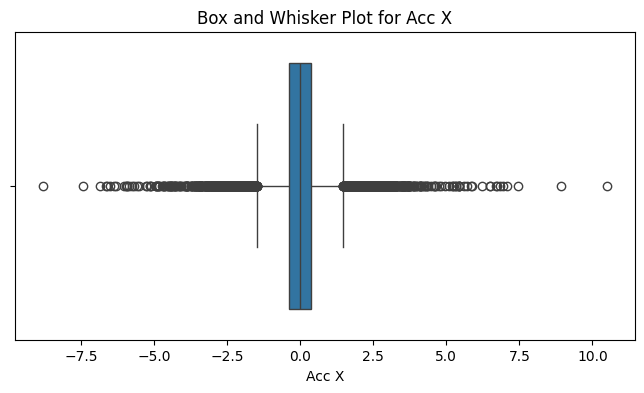

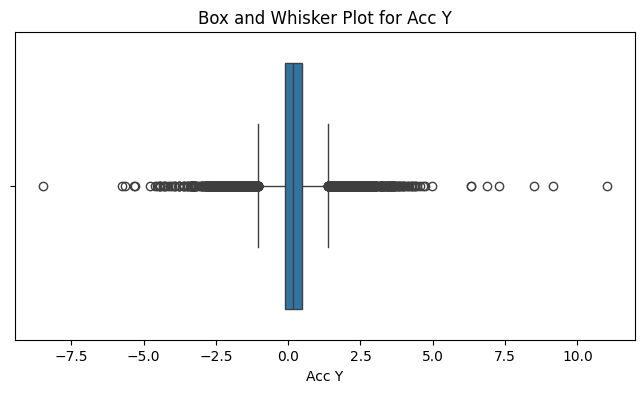

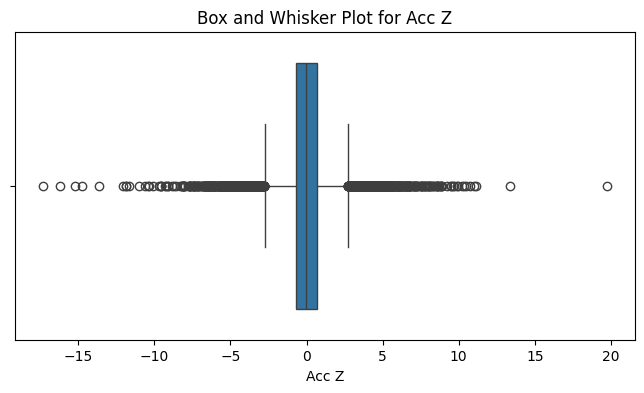

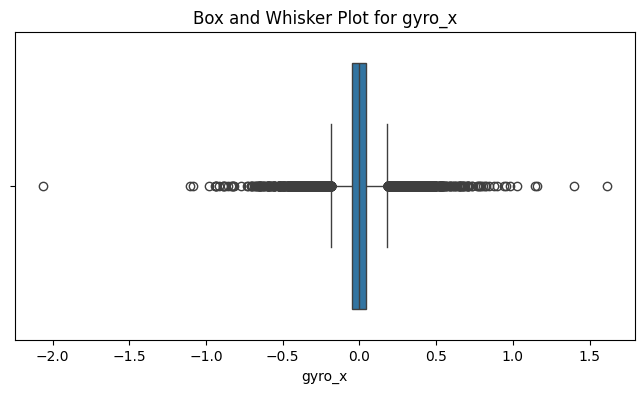

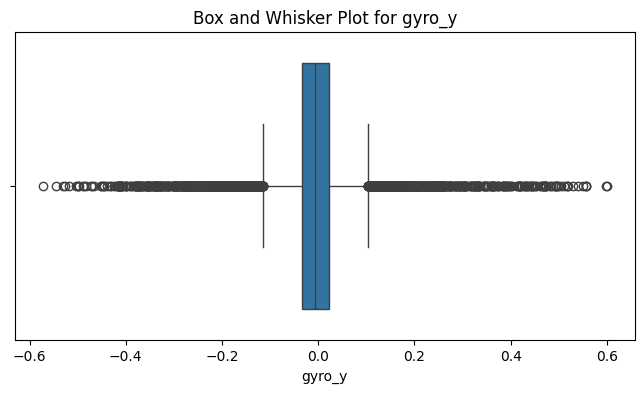

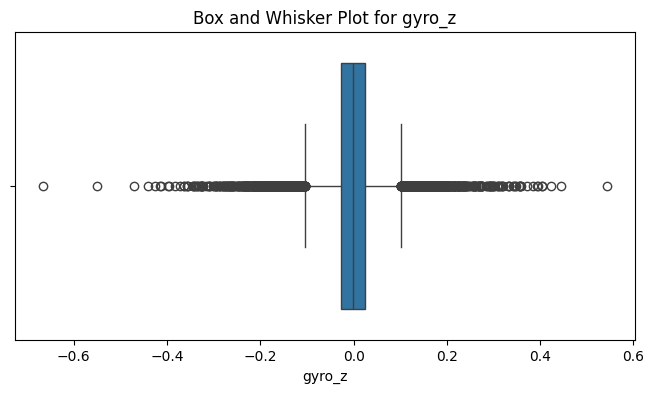

In [38]:
# 2. Exploratory Data Analysis (EDA) and Data Preprocessing
# Check for missing values and data types
print("Dataset Information:")
print(df.info())

print("\nMissing Values Count:")
print(df.isnull().sum())

# Drop or fill missing values as required (example: forward fill missing data)
df.fillna(method='ffill', inplace=True)

# Statistical summary
print("\nSummary Statistics:")
print(df.describe())

# Plotting distributions for key sensor data (Box and Whisker plot for outliers)
import seaborn as sns
import matplotlib.pyplot as plt

# Detecting outliers using separate Box and Whisker’s plot for each variable
# List of relevant columns (based on the dataset structure)
sensor_columns = ['Speed', 'Acc X', 'Acc Y', 'Acc Z', 'gyro_x', 'gyro_y', 'gyro_z']

# Plot separate Box and Whisker plots for each column
for col in sensor_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Box and Whisker Plot for {col}")
    plt.show()


**Task1 - Feature Engineering and Data Augmentation**


In [39]:
#new features (e.g., speed changes, sudden stops, direction changes).
#Calculate Speed Change & Direction Change
# Speed change (difference between consecutive rows)
df['Speed_Change'] = df['Speed'].diff()

# Direction change (Heading difference)
df['Direction_Change'] = df['Heading'].diff().fillna(0)

# Convert Time column to a proper datetime format
df['Time'] = pd.to_datetime(df['Time'], format='%H-%M-%S')
df['Time_Change'] = (df['Time'].diff().dt.total_seconds()).fillna(0)
# Acceleration Rate and Braking Intensity
df['Acceleration_Rate'] = df['Speed_Change'] / df['Time_Change']
df['Braking_Intensity'] = df['Acceleration_Rate'].apply(lambda x: x if x < 0 else 0)


#Jerk (Rate of Change of Acceleration)
df['Acc_Magnitude'] = np.sqrt(df['Acc X']**2 + df['Acc Y']**2 + df['Acc Z']**2)
df['Jerk'] = df['Acc_Magnitude'].diff() / df['Time_Change']

# Cumulative Distance and Speed Variance
df['Cumulative_Distance'] = df['Distance'].cumsum()
df['Speed_Variance'] = df['Speed'].rolling(window=5).var()


time-based features like rolling averages, moving variance for accelerometer and gyroscope data.

In [40]:
# Rolling average of Acc X over a window of 5 readings
df['Rolling_Mean_AccX'] = df['Acc X'].rolling(window=5).mean()

# Moving variance of gyro_x
df['Variance_GyroX'] = df['gyro_x'].rolling(window=5).var()


Engineer feature

In [41]:
# Total Acceleration from X, Y, Z components
df['Total_Acc'] = np.sqrt(df['Acc X']**2 + df['Acc Y']**2 + df['Acc Z']**2)


Feature Importance (Correlation)

Save the Updated Dataset

In [42]:
# Save the updated dataset
df.to_csv('augmented_dataset.csv', index=False)

**TASK 2**
Z-Score-Based Outlier Detection:

In [43]:
# Load the dataset
aug_df = pd.read_csv('augmented_dataset.csv')
print(aug_df.head())

   Longitude   Latitude  Speed  Distance                 Time     Acc X  \
0  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12  0.046402   
1  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:12 -0.136978   
2  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.045355   
3  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13  0.242089   
4  73.822661  18.501627    0.0       0.0  1900-01-01 18:45:13 -0.230234   

      Acc Y     Acc Z  Heading    gyro_x  ...  Time_Change  Acceleration_Rate  \
0 -0.137178 -0.282934      352 -0.036306  ...          0.0                NaN   
1  0.365242  0.108889      352  0.035776  ...          0.0                NaN   
2 -0.103340 -0.534985      352 -0.011871  ...          1.0                0.0   
3  0.072761 -0.350396      352 -0.017980  ...          0.0                NaN   
4  0.011765 -0.494085      352  0.011342  ...          0.0                NaN   

   Braking_Intensity  Acc_Magnitude      Jerk  Cumulative_Dist

Calculate Z-scores for the dataset and flag anomalies.

In [44]:
# Check for NaN values in the relevant columns
print(aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].isna().sum())


Speed                    0
Acceleration_Rate    11799
Jerk                     9
dtype: int64


In [45]:
#Handle NaN Values for Acceleration_Rate
# Fill NaN values with 0 for Acceleration_Rate
aug_df['Acceleration_Rate'] = aug_df['Acceleration_Rate'].fillna(0)
aug_df = aug_df.dropna(subset=['Acceleration_Rate'])



In [46]:
#Check Again
print(aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].isna().sum())


Speed                0
Acceleration_Rate    0
Jerk                 9
dtype: int64


In [47]:
aug_df['Jerk'] = aug_df['Jerk'].fillna(0)

In [48]:
#Check Again
print(aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].isna().sum())


Speed                0
Acceleration_Rate    0
Jerk                 0
dtype: int64


**Implement Z-score-based outlier detection.**

In [49]:
# Calculate Z-scores for the relevant columns
z_scores = aug_df[['Speed', 'Acceleration_Rate', 'Jerk']].apply(zscore)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:152: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


Flag anomalies where Z-score > 3 or < -3

In [50]:
# Flag anomalies where Z-score > 3 or < -3
aug_df['Anomaly'] = (np.abs(z_scores) > 3).any(axis=1).astype(int)


In [51]:
# Save the updated dataset
aug_df.to_csv('augmented_dataset.csv', index=False)

# Display anomalies if needed
anomalies = aug_df[aug_df['Anomaly'] == 1]
print(anomalies)

Empty DataFrame
Columns: [Longitude, Latitude, Speed, Distance, Time, Acc X, Acc Y, Acc Z, Heading, gyro_x, gyro_y, gyro_z, label, Speed_Change, Direction_Change, Time_Change, Acceleration_Rate, Braking_Intensity, Acc_Magnitude, Jerk, Cumulative_Distance, Speed_Variance, Rolling_Mean_AccX, Variance_GyroX, Total_Acc, Anomaly]
Index: []

[0 rows x 26 columns]


**Task 3**

Visualize anomalies using time-series plots and scatter plots.

Z-Score Detection Results:
       Longitude   Latitude  Speed   Distance                Time     Acc X  \
0      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:12  0.046402   
1      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:12 -0.136978   
2      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:13 -0.045355   
3      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:13  0.242089   
4      73.822661  18.501627    0.0     0.0000 1900-01-01 18:45:13 -0.230234   
...          ...        ...    ...        ...                 ...       ...   
14244  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14245  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14246  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14247  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:34 -0.436406   
14248  73.822813  18.501587    0.0  2096.5732 1900-01-01 17:27:35 -0.436406   

          Acc Y     Acc 

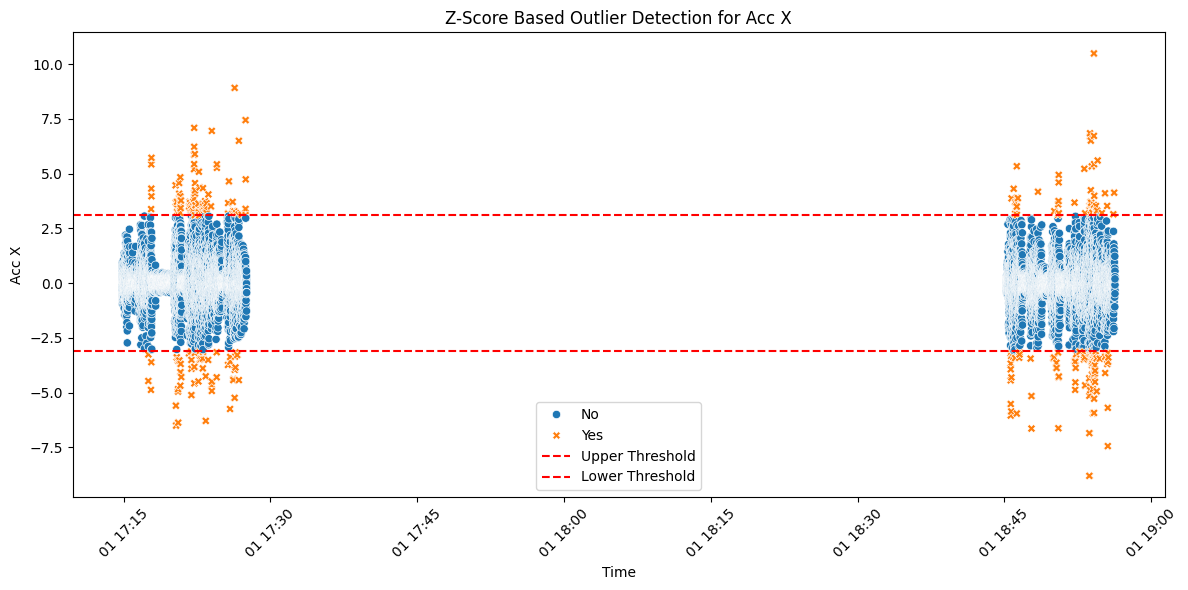

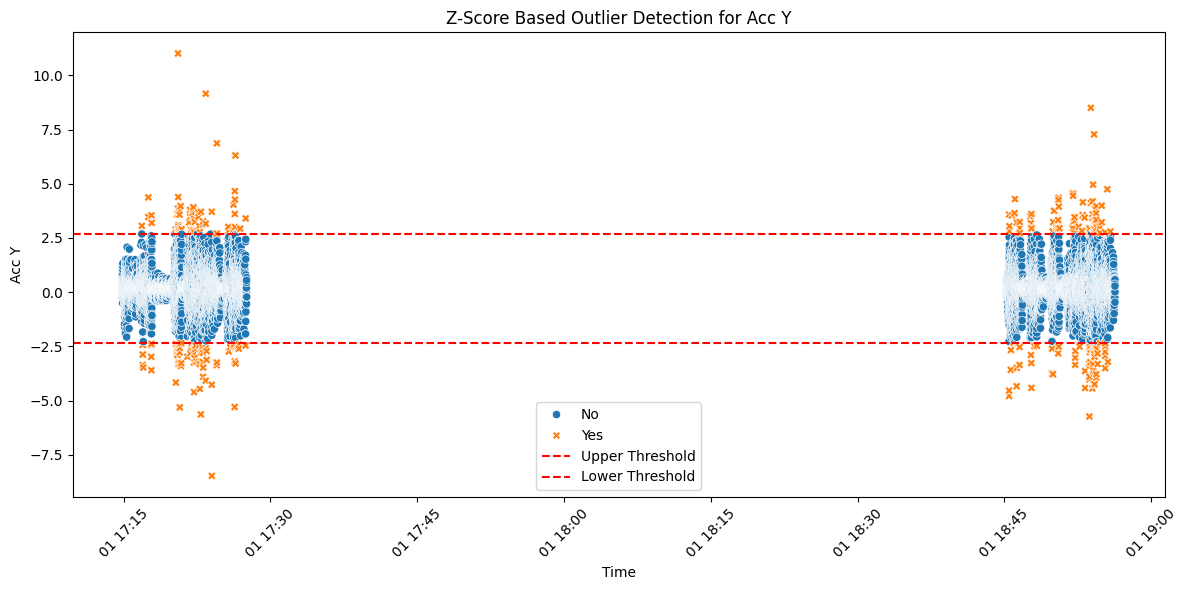

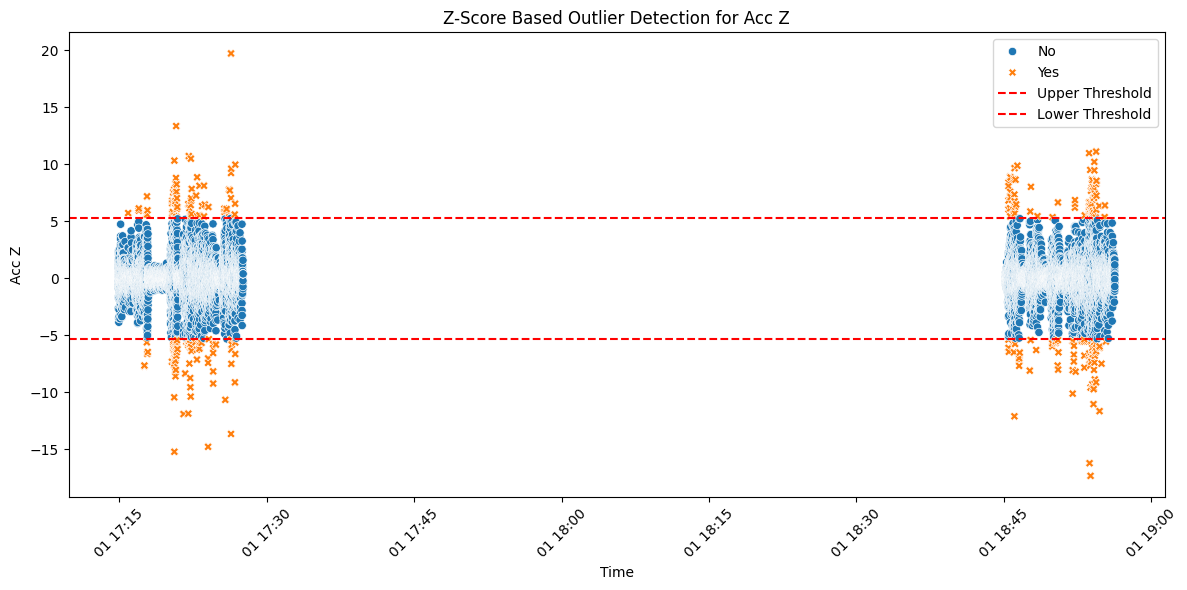

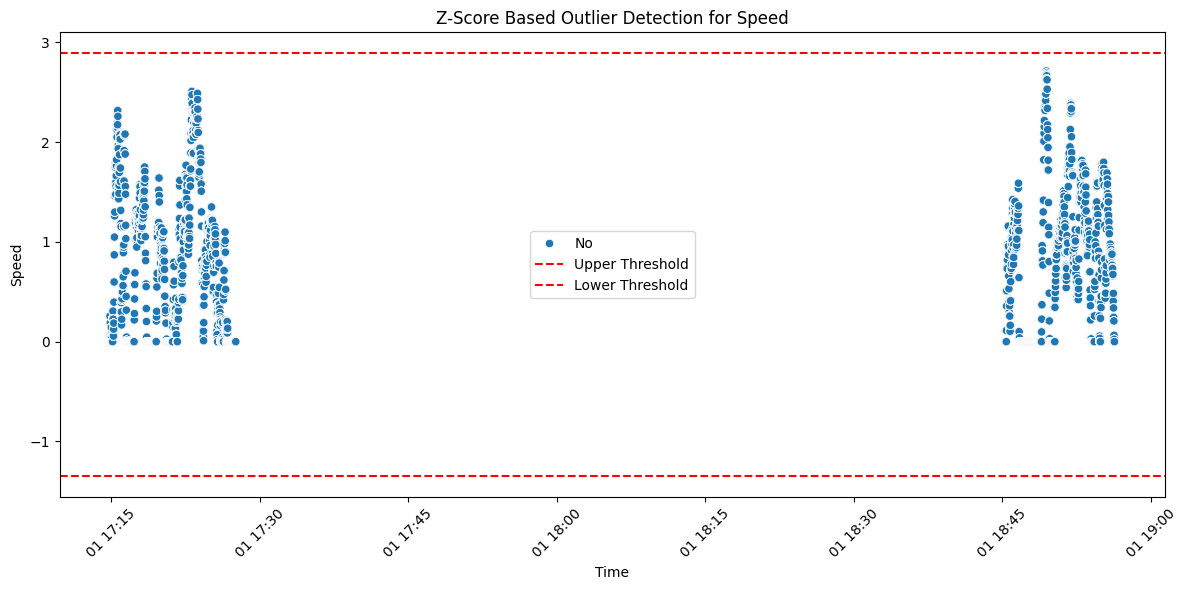

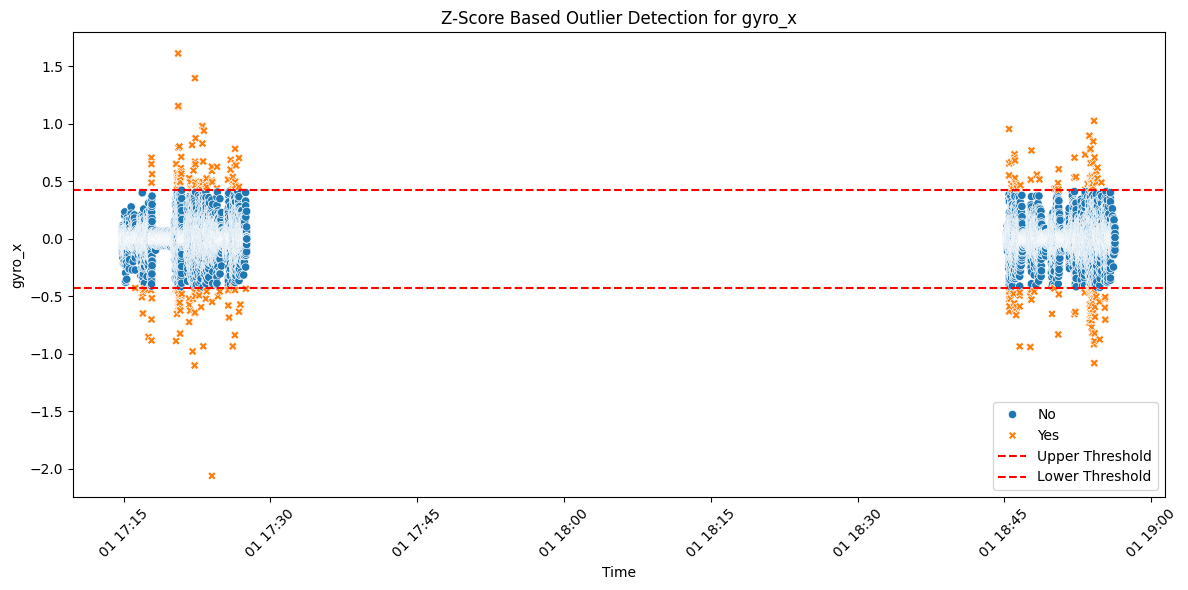

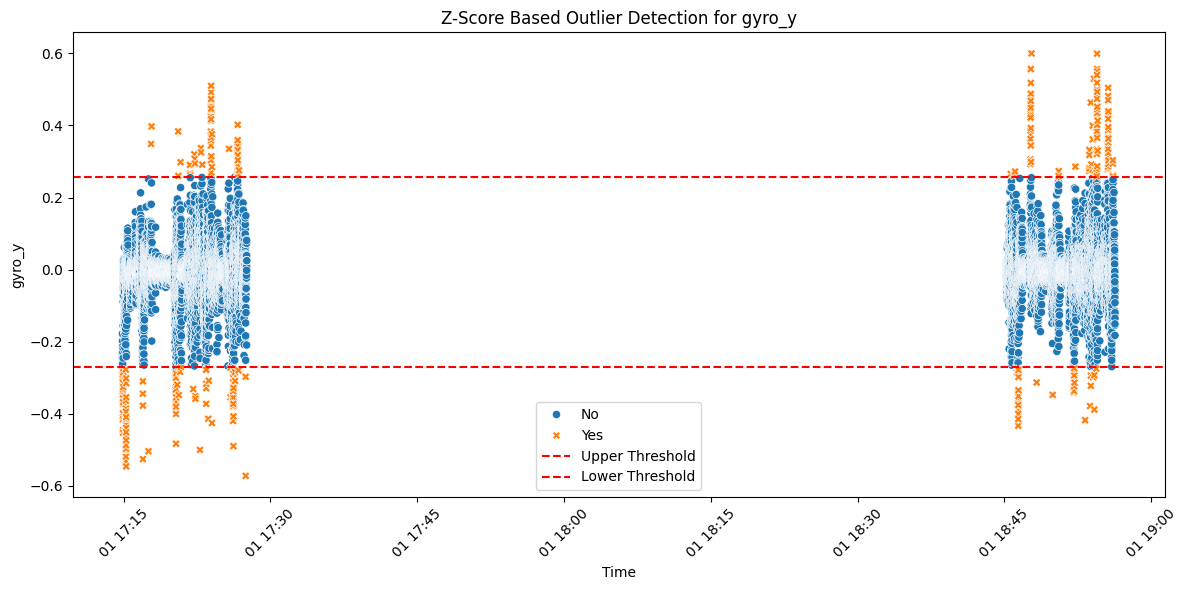

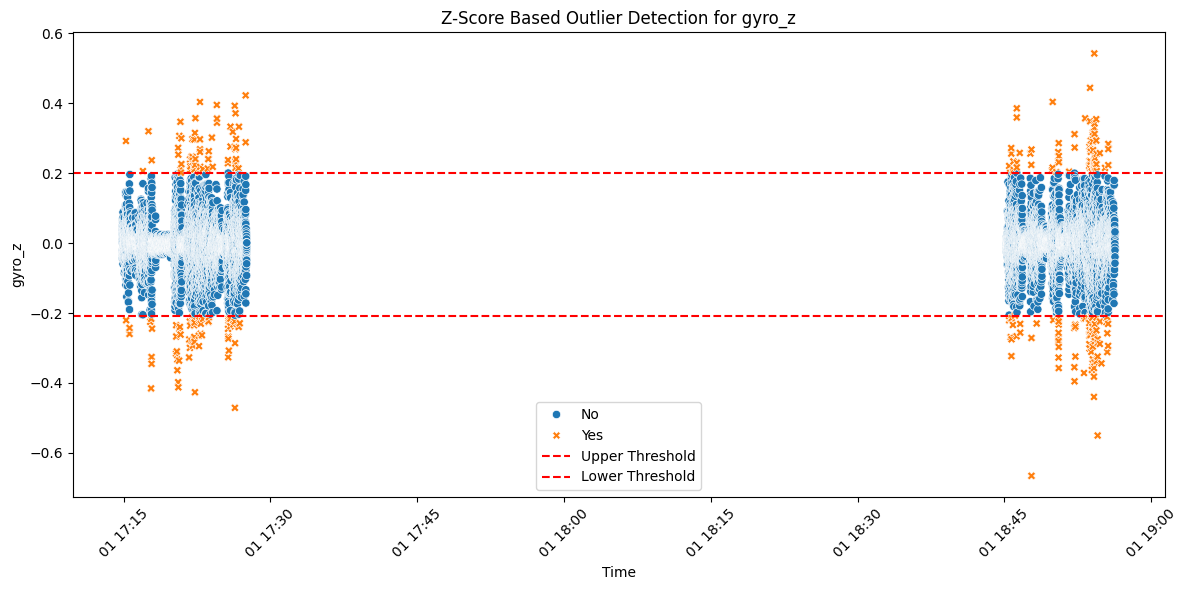

In [52]:

# Define a function for Z-score calculation and anomaly detection
def calculate_z_scores(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_scores = (df[column_name] - mean) / std          # Z= (X-mean)/sd
    df[f'Z-Score_{column_name}'] = z_scores
    df[f'Anomaly_{column_name}'] = z_scores.apply(lambda x: 'Yes' if abs(x) > 3 else 'No')

# List of parameters for which to calculate Z-scores
parameters = ['Acc X', 'Acc Y', 'Acc Z', 'Speed', 'gyro_x', 'gyro_y', 'gyro_z']

# Calculate Z-scores for each parameter
for param in parameters:
    calculate_z_scores(df, param)

# Display the results
print("Z-Score Detection Results:")
print(df)

# Visualize Z-scores and anomalies for all features
for param in parameters:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Time', y=param, hue=f'Anomaly_{param}', style=f'Anomaly_{param}', data=df)
    plt.axhline(y=df[param].mean() + 3 * df[param].std(), color='r', linestyle='--', label='Upper Threshold')
    plt.axhline(y=df[param].mean() - 3 * df[param].std(), color='r', linestyle='--', label='Lower Threshold')
    plt.title(f'Z-Score Based Outlier Detection for {param}')
    plt.xlabel('Time')
    plt.ylabel(param)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# In a normal distribution:
# Approximately 68% of the data falls within 1 standard deviation from the mean.
# Approximately 95% of the data falls within 2 standard deviations from the mean.
# Approximately 99.7% of the data falls within 3 standard deviations from the mean.
# Thus, if a data point has a Z-score greater than 3 or less than -3, it is considered an outlier since it falls outside the range where 99.7% of the data points lie.


Compare Z-score and IQR results

Joint Comparison of Z-score and IQR Anomalies:
         Acc X    Acc Y    Acc Z    Speed   gyro_x   gyro_y   gyro_z
0      No | No  No | No  No | No  No | No  No | No  No | No  No | No
1      No | No  No | No  No | No  No | No  No | No  No | No  No | No
2      No | No  No | No  No | No  No | No  No | No  No | No  No | No
3      No | No  No | No  No | No  No | No  No | No  No | No  No | No
4      No | No  No | No  No | No  No | No  No | No  No | No  No | No
...        ...      ...      ...      ...      ...      ...      ...
14244  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14245  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14246  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14247  No | No  No | No  No | No  No | No  No | No  No | No  No | No
14248  No | No  No | No  No | No  No | No  No | No  No | No  No | No

[14249 rows x 7 columns]


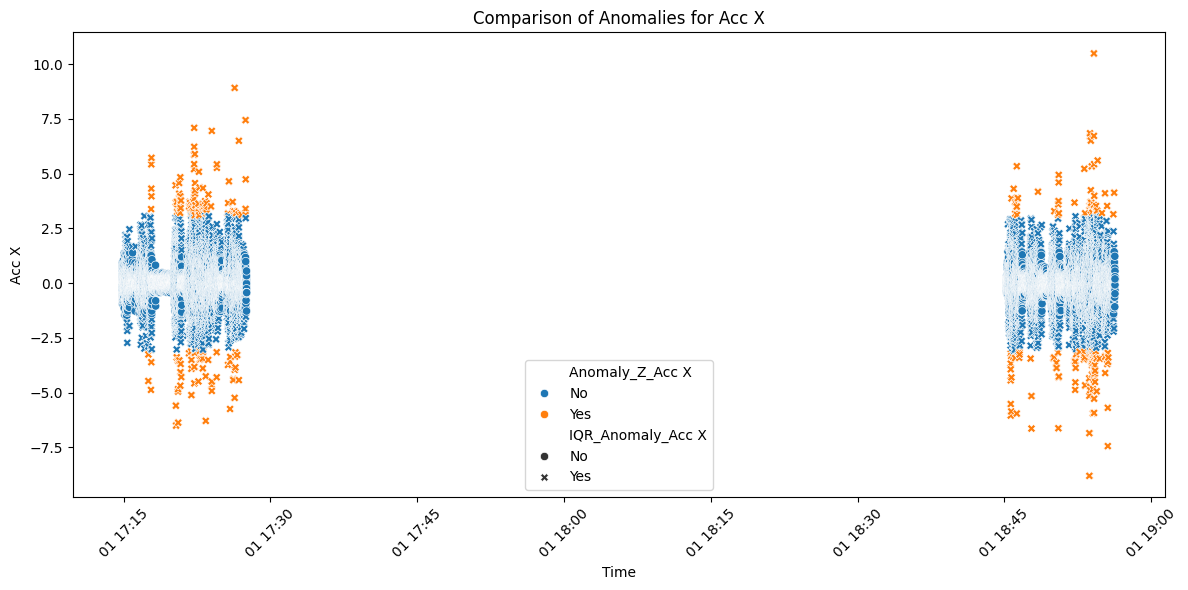

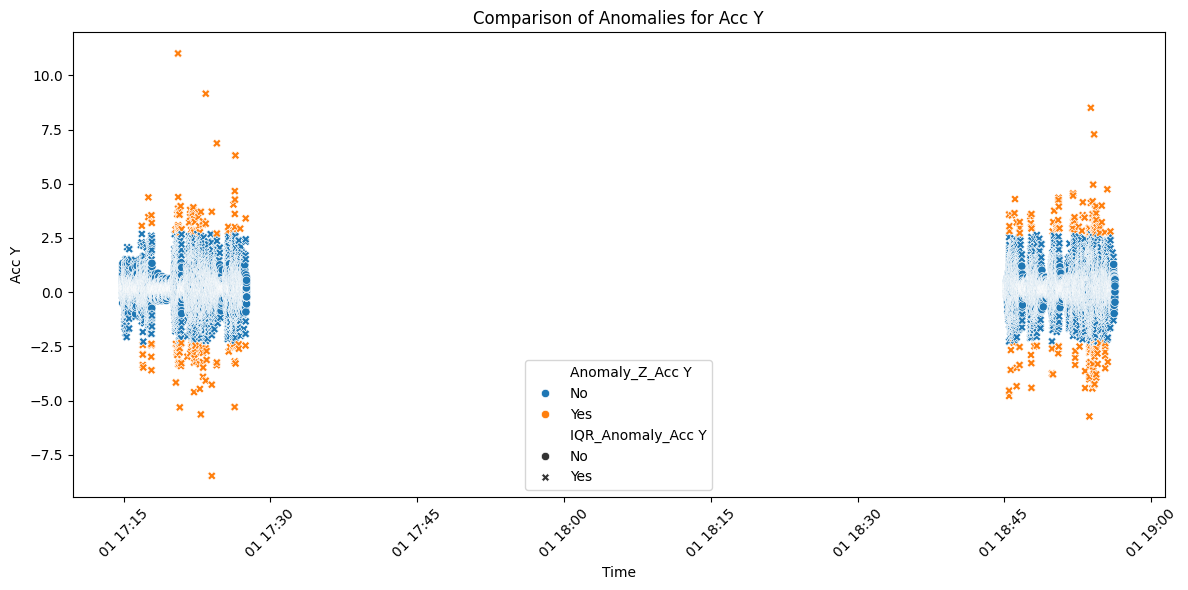

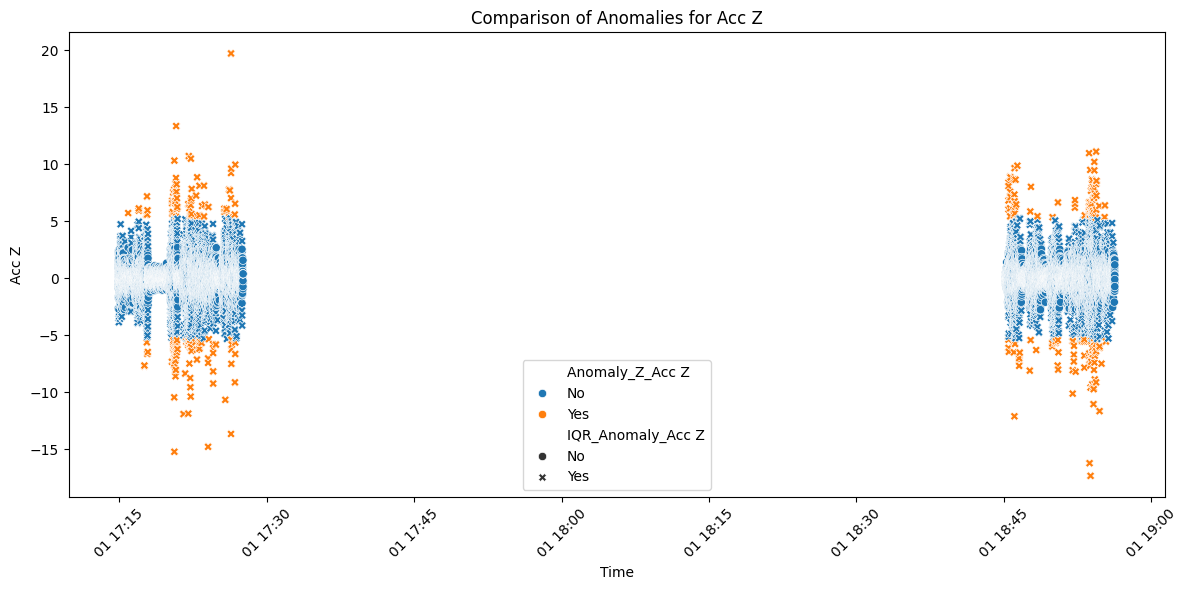

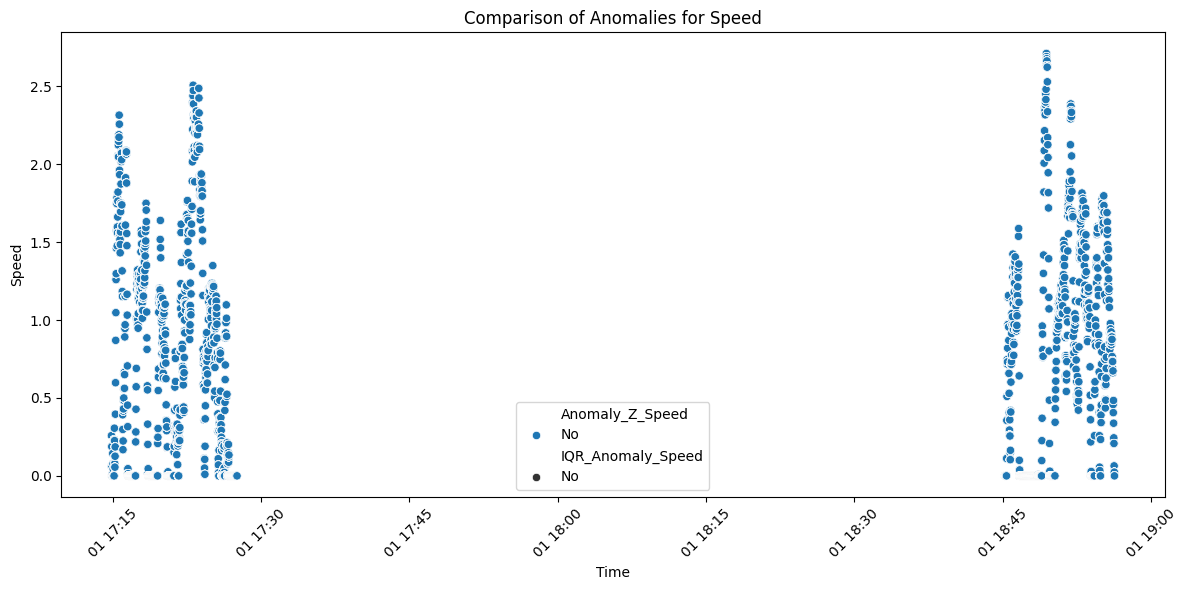

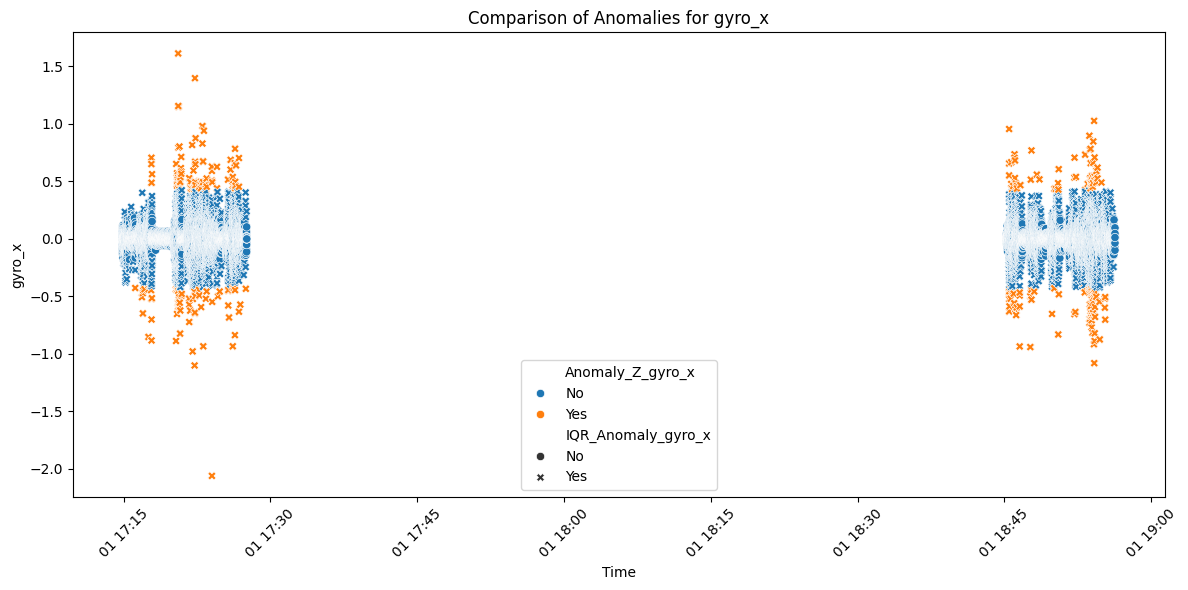

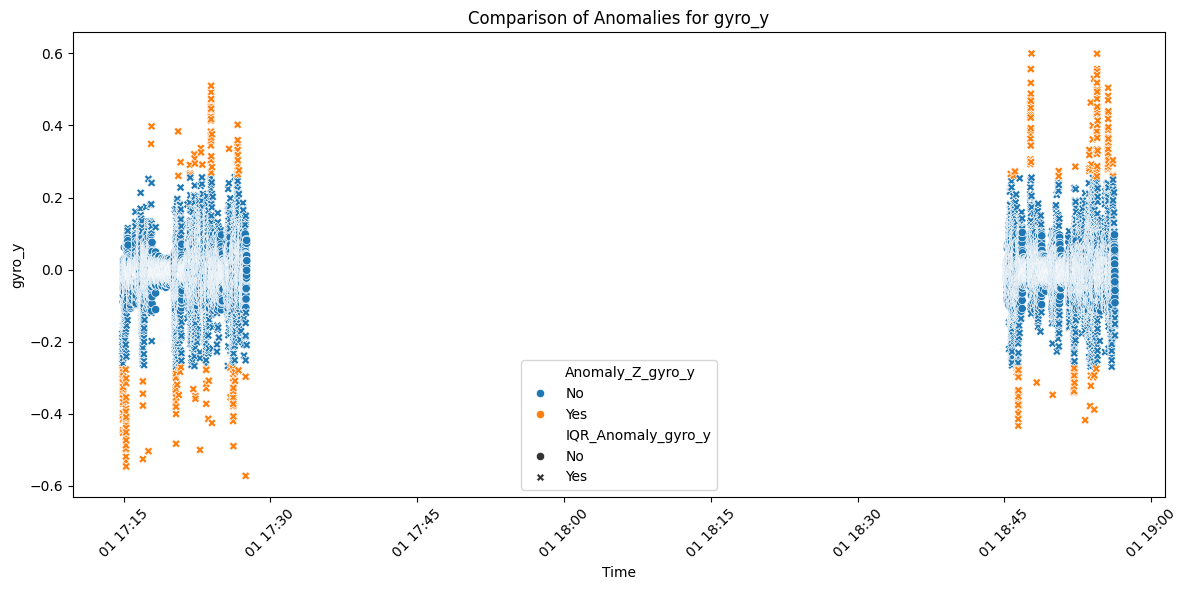

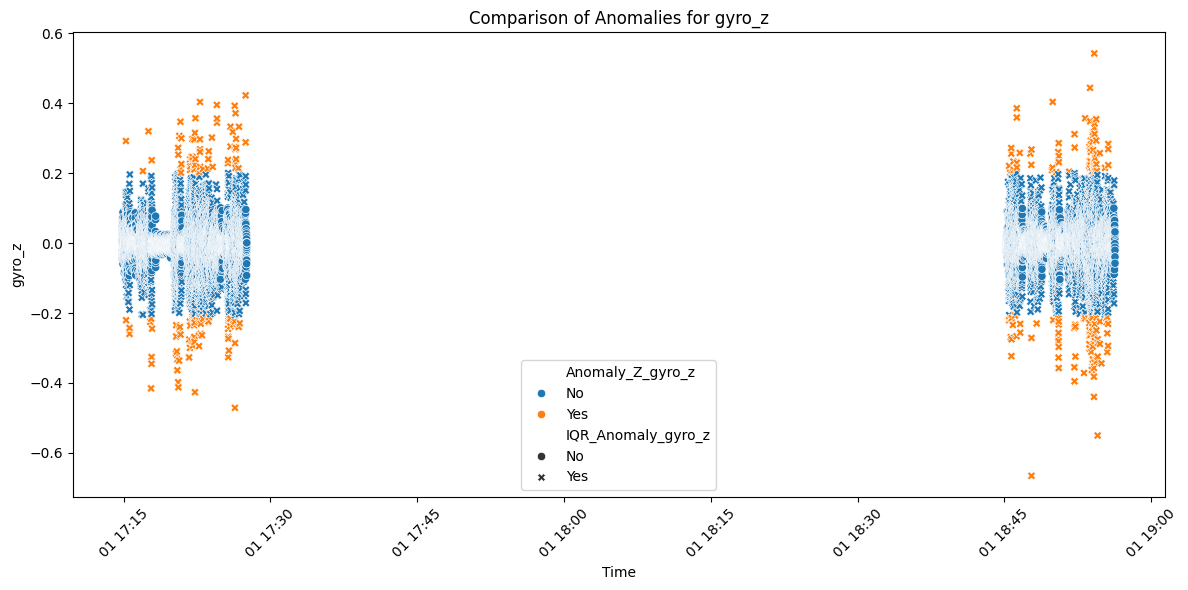

In [53]:
# Define a function for Z-score calculation and anomaly detection
def calculate_z_scores(df, column_name):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_scores = (df[column_name] - mean) / std
    df[f'Z-Score_{column_name}'] = z_scores
    df[f'Anomaly_Z_{column_name}'] = z_scores.apply(lambda x: 'Yes' if abs(x) > 3 else 'No')

# Define a function for IQR calculation and anomaly detection
def calculate_iqr_anomalies(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[f'IQR_Anomaly_{column_name}'] = df[column_name].apply(
        lambda x: 'Yes' if x < lower_bound or x > upper_bound else 'No'
    )

# List of parameters for which to calculate anomalies
parameters = ['Acc X', 'Acc Y', 'Acc Z', 'Speed', 'gyro_x', 'gyro_y', 'gyro_z']

# Calculate anomalies using Z-scores
for param in parameters:
    calculate_z_scores(df, param)

# Calculate anomalies using IQR
for param in parameters:
    calculate_iqr_anomalies(df, param)

# Compare results
comparison_results = {}
for param in parameters:
    z_anomalies = df[f'Anomaly_Z_{param}']
    iqr_anomalies = df[f'IQR_Anomaly_{param}']

    # Create a combined comparison column
    comparison_results[param] = pd.Series(z_anomalies + " | " + iqr_anomalies)

# Create a summary DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Display the comparison DataFrame
print("Joint Comparison of Z-score and IQR Anomalies:")
print(comparison_df)

# Optional: Visualize results if needed
for param in parameters:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Time', y=param, hue=f'Anomaly_Z_{param}', style=f'IQR_Anomaly_{param}', data=df)
    plt.title(f'Comparison of Anomalies for {param}')
    plt.xlabel('Time')
    plt.ylabel(param)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


# **Task 4**
**Z-Score-Based Outlier Detection**

Re-evaluate the Z-score threshold values for each sensor, test different thresholds (e.g., Z-scores of 2, 2.5, 3) and compare the results.

In [54]:
# Modify Z-score function to accept dynamic threshold
def calculate_z_scores(df, column_name, threshold=3):
    mean = df[column_name].mean()
    std = df[column_name].std()
    z_scores = (df[column_name] - mean) / std
    df[f'Z-Score_{column_name}'] = z_scores
    df[f'Anomaly_Z_{column_name}_T{threshold}'] = z_scores.apply(lambda x: 'Yes' if abs(x) > threshold else 'No')

# List of thresholds to test
thresholds = [2, 2.5, 3]

# Run Z-score anomaly detection for each threshold
for threshold in thresholds:
    for param in parameters:
        calculate_z_scores(df, param, threshold)

# Now, compare the results
for param in parameters:
    print(f"Anomaly Comparison for {param} across thresholds:")
    for threshold in thresholds:
        anomaly_col = f'Anomaly_Z_{param}_T{threshold}'
        print(f"Threshold {threshold}: {df[anomaly_col].value_counts()}")


Anomaly Comparison for Acc X across thresholds:
Threshold 2: Anomaly_Z_Acc X_T2
No     13427
Yes      822
Name: count, dtype: int64
Threshold 2.5: Anomaly_Z_Acc X_T2.5
No     13774
Yes      475
Name: count, dtype: int64
Threshold 3: Anomaly_Z_Acc X_T3
No     13975
Yes      274
Name: count, dtype: int64
Anomaly Comparison for Acc Y across thresholds:
Threshold 2: Anomaly_Z_Acc Y_T2
No     13411
Yes      838
Name: count, dtype: int64
Threshold 2.5: Anomaly_Z_Acc Y_T2.5
No     13778
Yes      471
Name: count, dtype: int64
Threshold 3: Anomaly_Z_Acc Y_T3
No     13969
Yes      280
Name: count, dtype: int64
Anomaly Comparison for Acc Z across thresholds:
Threshold 2: Anomaly_Z_Acc Z_T2
No     13434
Yes      815
Name: count, dtype: int64
Threshold 2.5: Anomaly_Z_Acc Z_T2.5
No     13760
Yes      489
Name: count, dtype: int64
Threshold 3: Anomaly_Z_Acc Z_T3
No     13956
Yes      293
Name: count, dtype: int64
Anomaly Comparison for Speed across thresholds:
Threshold 2: Anomaly_Z_Speed_T2
No     1

Experiment with standardization techniques, such as Min-Max scaling, to see how they impact Z-score anomaly detection.

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Define a function for Min-Max scaling
def min_max_scale(df, column_name):
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[[column_name]])
    df[f'Scaled_{column_name}'] = scaled_values

# Step 2: Modify the Z-score function to accept scaled data
def calculate_scaled_z_scores(df, column_name, threshold=3):
    mean = df[f'Scaled_{column_name}'].mean()
    std = df[f'Scaled_{column_name}'].std()
    z_scores = (df[f'Scaled_{column_name}'] - mean) / std
    df[f'Z-Score_Scaled_{column_name}'] = z_scores
    df[f'Anomaly_Z_Scaled_{column_name}_T{threshold}'] = z_scores.apply(
        lambda x: 'Yes' if abs(x) > threshold else 'No'
    )

# Step 3: Apply Min-Max scaling to all parameters
for param in parameters:
    min_max_scale(df, param)

# Step 4: Run Z-Score detection using scaled data with different thresholds
thresholds = [2, 2.5, 3]

for threshold in thresholds:
    for param in parameters:
        calculate_scaled_z_scores(df, param, threshold)

# Step 5: Compare results across original and scaled Z-Score anomalies
for param in parameters:
    print(f"Anomaly Comparison for {param} (Original vs Scaled) across thresholds:")
    for threshold in thresholds:
        original_anomaly_col = f'Anomaly_Z_{param}_T{threshold}'
        scaled_anomaly_col = f'Anomaly_Z_Scaled_{param}_T{threshold}'
        print(f"Threshold {threshold} (Original): {df[original_anomaly_col].value_counts()}")
        print(f"Threshold {threshold} (Scaled): {df[scaled_anomaly_col].value_counts()}")


Anomaly Comparison for Acc X (Original vs Scaled) across thresholds:
Threshold 2 (Original): Anomaly_Z_Acc X_T2
No     13427
Yes      822
Name: count, dtype: int64
Threshold 2 (Scaled): Anomaly_Z_Scaled_Acc X_T2
No     13427
Yes      822
Name: count, dtype: int64
Threshold 2.5 (Original): Anomaly_Z_Acc X_T2.5
No     13774
Yes      475
Name: count, dtype: int64
Threshold 2.5 (Scaled): Anomaly_Z_Scaled_Acc X_T2.5
No     13774
Yes      475
Name: count, dtype: int64
Threshold 3 (Original): Anomaly_Z_Acc X_T3
No     13975
Yes      274
Name: count, dtype: int64
Threshold 3 (Scaled): Anomaly_Z_Scaled_Acc X_T3
No     13975
Yes      274
Name: count, dtype: int64
Anomaly Comparison for Acc Y (Original vs Scaled) across thresholds:
Threshold 2 (Original): Anomaly_Z_Acc Y_T2
No     13411
Yes      838
Name: count, dtype: int64
Threshold 2 (Scaled): Anomaly_Z_Scaled_Acc Y_T2
No     13411
Yes      838
Name: count, dtype: int64
Threshold 2.5 (Original): Anomaly_Z_Acc Y_T2.5
No     13778
Yes      471
N

# Task 5

**Step 1: Implement Isolation Forest**

1.1 Import Necessary Libraries

First, ensure you have the required libraries imported:

In [56]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

1.2 Prepare the Dataset

Assuming you already have the anomaly labels from Z-Score results, create a binary label for true anomalies:

In [57]:
# Load the dataset
data = pd.read_csv('augmented_dataset.csv')

# Create a true anomaly label if it's not already present
# Assuming the 'Anomaly' column indicates the presence of an anomaly
data['true_anomaly'] = data['Anomaly'].astype(int)


**Step 2: Feature Selection**

Select relevant features for the Isolation Forest model. You can choose the original sensor readings or the engineered features.



In [58]:
# Feature selection
features = ['Acc X', 'Acc Y', 'Acc Z', 'Speed', 'Acceleration_Rate', 'Total_Acc']
X = data[features]


In [59]:
print(X.isnull().sum())  # Check for missing values
print(np.isinf(X).sum())  # Check for infinite values


Acc X                0
Acc Y                0
Acc Z                0
Speed                0
Acceleration_Rate    0
Total_Acc            0
dtype: int64
Acc X                   0
Acc Y                   0
Acc Z                   0
Speed                   0
Acceleration_Rate    1021
Total_Acc               0
dtype: int64


In [60]:
X.loc[:, 'Acceleration_Rate'] = X['Acceleration_Rate'].replace([np.inf, -np.inf], X['Acceleration_Rate'][np.isfinite(X['Acceleration_Rate'])].max())


**Step 3: Implement Isolation Forest**

Now, fit the Isolation Forest model to your selected features.

In [61]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data['iso_forest_anomaly'] = iso_forest.fit_predict(X)

# Convert predictions to binary (1 for anomaly, 0 for normal)
data['iso_forest_anomaly'] = (data['iso_forest_anomaly'] == -1).astype(int)


**Step 4: Compare with Statistical Methods**

Now you can calculate the confusion matrix and classification report to evaluate the performance of Isolation Forest against IQR and Z-Score methods.

Implement IQR and Z-Score Anomaly Detection
If you haven't already created the IQR and Z-Score anomaly columns, you'll need to do that first.

IQR Method

In [62]:
# Calculate IQR
Q1 = data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']].quantile(0.25)
Q3 = data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']].quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Anomaly detection using IQR
data['IQR_anomaly'] = ((data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']] < lower_bound) |
                        (data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']] > upper_bound)).any(axis=1).astype(int)


Z-Score Method

In [63]:
from scipy.stats import zscore

# Calculate Z-Scores for each feature and assign to separate columns
data[['Z_Score_Acc_X', 'Z_Score_Acc_Y', 'Z_Score_Acc_Z', 'Z_Score_Speed']] = zscore(data[['Acc X', 'Acc Y', 'Acc Z', 'Speed']], nan_policy='omit')

# Define a threshold for anomalies
threshold = 3

# Anomaly detection based on Z-Score
data['Z_Score_anomaly'] = ((data[['Z_Score_Acc_X', 'Z_Score_Acc_Y', 'Z_Score_Acc_Z', 'Z_Score_Speed']] > threshold).any(axis=1)).astype(int)


**Now Compare with Statistical Methods**

Once you have the IQR_anomaly and Z_Score_anomaly columns in your DataFrame, you can proceed with the comparison as outlined previously:

In [64]:
from sklearn.metrics import confusion_matrix, classification_report

# Now that we have the necessary columns, we can perform the comparison
iqr_results = data['IQR_anomaly']
z_score_results = data['Z_Score_anomaly']

# Calculate confusion matrices and classification reports
conf_matrix_iso = confusion_matrix(data['true_anomaly'], data['iso_forest_anomaly'])
conf_matrix_iqr = confusion_matrix(data['true_anomaly'], iqr_results)
conf_matrix_zscore = confusion_matrix(data['true_anomaly'], z_score_results)

class_report_iso = classification_report(data['true_anomaly'], data['iso_forest_anomaly'])
class_report_iqr = classification_report(data['true_anomaly'], iqr_results)
class_report_zscore = classification_report(data['true_anomaly'], z_score_results)

print("Isolation Forest Classification Report:\n", class_report_iso)
print("IQR Classification Report:\n", class_report_iqr)
print("Z-Score Classification Report:\n", class_report_zscore)


Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95     14249
           1       0.00      0.00      0.00         0

    accuracy                           0.90     14249
   macro avg       0.50      0.45      0.47     14249
weighted avg       1.00      0.90      0.95     14249

IQR Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87     14249
           1       0.00      0.00      0.00         0

    accuracy                           0.77     14249
   macro avg       0.50      0.39      0.44     14249
weighted avg       1.00      0.77      0.87     14249

Z-Score Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     14249
           1       0.00      0.00      0.00         0

    accuracy                           0.97     14249
   macro avg       0.50    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

Step 5: Visualize Confusion Matrix

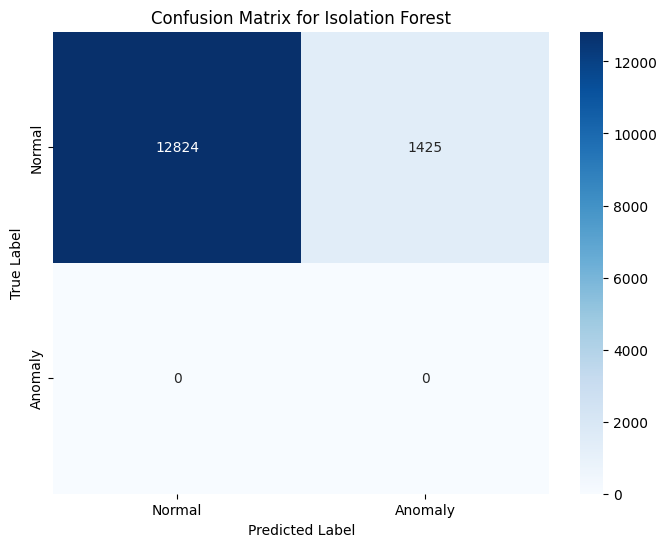

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_iso, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Isolation Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Step 6: Performance Metrics Comparison

Calculate and compare performance metrics like precision, recall, F1-score, and accuracy for all three methods.

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, predicted_labels):
    return {
        'Accuracy': accuracy_score(true_labels, predicted_labels),
        'Precision': precision_score(true_labels, predicted_labels),
        'Recall': recall_score(true_labels, predicted_labels),
        'F1 Score': f1_score(true_labels, predicted_labels),
    }

# Performance Metrics for each method
performance_metrics = {
    'Isolation Forest': calculate_metrics(data['true_anomaly'], data['iso_forest_anomaly']),
    'IQR': calculate_metrics(data['true_anomaly'], iqr_results),
    'Z-Score': calculate_metrics(data['true_anomaly'], z_score_results),
}

# Display performance metrics
metrics_df = pd.DataFrame(performance_metrics).T
print(metrics_df)


                  Accuracy  Precision  Recall  F1 Score
Isolation Forest  0.899993        0.0     0.0       0.0
IQR               0.773177        0.0     0.0       0.0
Z-Score           0.972138        0.0     0.0       0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Step 7: Visualization of Performance Metrics**

You can visualize the performance metrics using a bar plot.

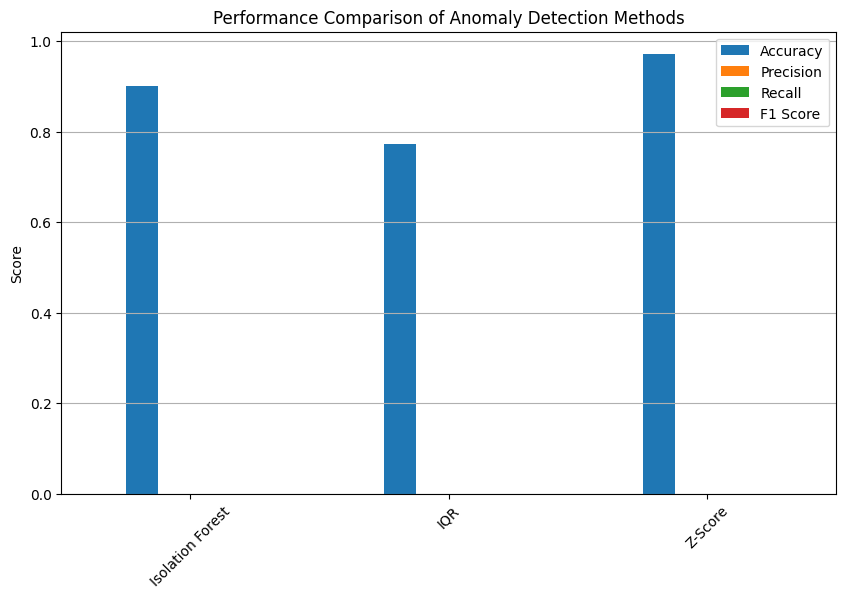

In [67]:
metrics_df.plot(kind='bar', figsize=(10, 6))
plt.title('Performance Comparison of Anomaly Detection Methods')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# TASK 6

**Objective:** Analyze the performance of the Isolation Forest model for anomaly detection, compare it with the IQR and Z-Score methods, and examine precision-recall metrics to assess model effectiveness.



**Step 1: Calculate Precision, Recall, and F1-Score for Isolation Forest**

Precision, recall, and F1-score are key metrics for evaluating model accuracy. Precision measures the model’s accuracy in identifying anomalies among flagged cases, recall measures the model’s ability to capture all anomalies, and F1-score represents the balance between precision and recall.

In [68]:
# Import necessary libraries
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision, Recall, and F1-Score
precision = precision_score(data['true_anomaly'], data['iso_forest_anomaly'])
recall = recall_score(data['true_anomaly'], data['iso_forest_anomaly'])
f1 = f1_score(data['true_anomaly'], data['iso_forest_anomaly'])

# Display the results
print("Isolation Forest Performance Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Isolation Forest Performance Metrics:
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Step 2: Plot Precision-Recall Curve**

The precision-recall curve is a valuable tool for visualizing the trade-off between precision and recall at various threshold settings. This helps identify an optimal threshold, maximizing the model’s efficiency in anomaly detection.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


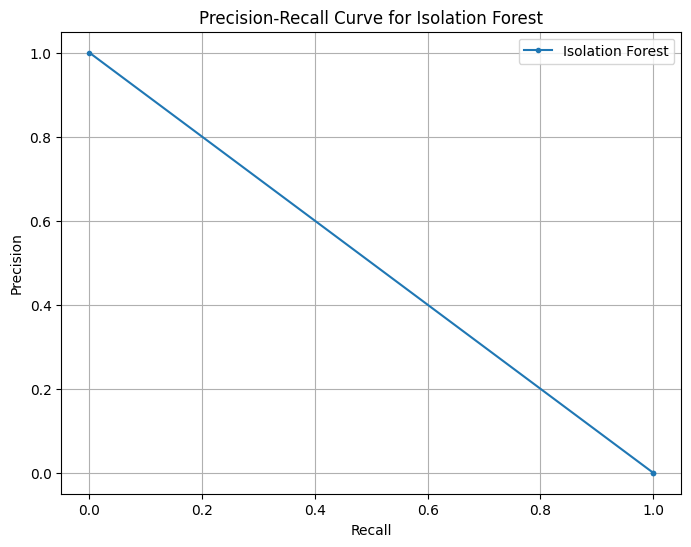

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Generate precision-recall values for different thresholds
precision_values, recall_values, thresholds = precision_recall_curve(data['true_anomaly'], data['iso_forest_anomaly'])

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, marker='.', label='Isolation Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.legend()
plt.grid(True)
plt.show()

**Step 3: Identify False Positives and False Negatives**

False positives are normal cases incorrectly flagged as anomalies, while false negatives are actual anomalies missed by the model. Identifying these cases helps us understand model limitations and areas for improvement.

In [70]:
# Identify False Positives and False Negatives
false_positives = data[(data['iso_forest_anomaly'] == 1) & (data['true_anomaly'] == 0)]
false_negatives = data[(data['iso_forest_anomaly'] == 0) & (data['true_anomaly'] == 1)]

# Display counts of false positives and false negatives
print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))

Number of False Positives: 1425
Number of False Negatives: 0


**Step 4: Compare Results with Previous Methods (IQR, Z-Score)**

To gauge the performance of Isolation Forest relative to previous methods, calculate and compare precision, recall, and F1-score values for IQR and Z-score methods. This comparison will highlight which technique offers the most accurate anomaly detection.

In [71]:
# Classification reports for IQR and Z-Score
iqr_report = classification_report(data['true_anomaly'], data['IQR_anomaly'], target_names=['Normal', 'Anomaly'])
z_score_report = classification_report(data['true_anomaly'], data['Z_Score_anomaly'], target_names=['Normal', 'Anomaly'])

print("IQR Classification Report:\n", iqr_report)
print("Z-Score Classification Report:\n", z_score_report)

IQR Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.77      0.87     14249
     Anomaly       0.00      0.00      0.00         0

    accuracy                           0.77     14249
   macro avg       0.50      0.39      0.44     14249
weighted avg       1.00      0.77      0.87     14249

Z-Score Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     14249
     Anomaly       0.00      0.00      0.00         0

    accuracy                           0.97     14249
   macro avg       0.50      0.49      0.49     14249
weighted avg       1.00      0.97      0.99     14249



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.p

# TASK *7*

Objective: Further analyze the performance of the Isolation Forest model by calculating key metrics, visualizing the precision-recall curve, and documenting false positives and false negatives to improve the model’s effectiveness.

Step 1: Calculate Precision, Recall, and F1-Score
This step calculates the metrics using anomalies identified by the model, rather than relying on predefined known anomalies. This ensures the performance is analyzed based on the model's own output.

In [72]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate Precision, Recall, and F1-Score based on model-identified anomalies
precision = precision_score(data['true_anomaly'], data['iso_forest_anomaly'])
recall = recall_score(data['true_anomaly'], data['iso_forest_anomaly'])
f1 = f1_score(data['true_anomaly'], data['iso_forest_anomaly'])

# Display the results
print("Isolation Forest - Identified Anomalies Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Isolation Forest - Identified Anomalies Metrics:
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Step 2: Plot Precision-Recall Curve
Visualize the precision-recall trade-off to determine an ideal threshold for the Isolation Forest model. This step can help in fine-tuning the detection threshold to improve accuracy.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


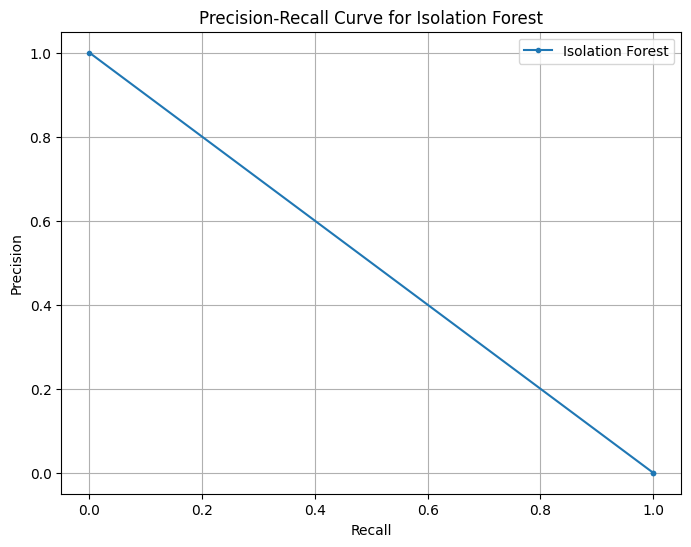

In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Generate precision-recall values
precision_values, recall_values, thresholds = precision_recall_curve(data['true_anomaly'], data['iso_forest_anomaly'])

# Plot the Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, marker='.', label='Isolation Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.legend()
plt.grid(True)
plt.show()


Step 3: Analyze and Document False Positives and False Negatives
Identify and document false positives and false negatives, focusing on cases where the model incorrectly predicted normal or anomalous behavior. This documentation will help to analyze patterns and improve future performance.

In [74]:
# Identify and document False Positives and False Negatives
false_positives = data[(data['iso_forest_anomaly'] == 1) & (data['true_anomaly'] == 0)]
false_negatives = data[(data['iso_forest_anomaly'] == 0) & (data['true_anomaly'] == 1)]

# Display counts
print("False Positives Identified:", len(false_positives))
print("False Negatives Identified:", len(false_negatives))

# Optional: Save the identified cases for further analysis
false_positives.to_csv('false_positives.csv', index=False)
false_negatives.to_csv('false_negatives.csv', index=False)


False Positives Identified: 1425
False Negatives Identified: 0


In [75]:
data.columns


Index(['Longitude', 'Latitude', 'Speed', 'Distance', 'Time', 'Acc X', 'Acc Y',
       'Acc Z', 'Heading', 'gyro_x', 'gyro_y', 'gyro_z', 'label',
       'Speed_Change', 'Direction_Change', 'Time_Change', 'Acceleration_Rate',
       'Braking_Intensity', 'Acc_Magnitude', 'Jerk', 'Cumulative_Distance',
       'Speed_Variance', 'Rolling_Mean_AccX', 'Variance_GyroX', 'Total_Acc',
       'Anomaly', 'true_anomaly', 'iso_forest_anomaly', 'IQR_anomaly',
       'Z_Score_Acc_X', 'Z_Score_Acc_Y', 'Z_Score_Acc_Z', 'Z_Score_Speed',
       'Z_Score_anomaly'],
      dtype='object')

# Task 8
# Evaluate the models’ computational efficiency and scalability


Evaluating computational efficiency and scalability involves analyzing how each anomaly detection model performs in terms of speed and resource use, especially as the dataset grows. Let’s break down how to approach Task 8 for Isolation Forest, IQR, and Z-Score methods.

# Step 1: Measuring Computational Efficiency
**1. Execution Time**

Track the time taken by each model to train and predict anomalies on the current dataset. Use Python’s time library to measure the start and end time for each method.

In [76]:
import time

# Isolation Forest
start_time = time.time()
iso_forest.fit(X)
data['iso_forest_anomaly'] = iso_forest.predict(X)
iso_time = time.time() - start_time
print("Isolation Forest Time:", iso_time)

# IQR
start_time = time.time()
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['IQR_anomaly'] = ((X < lower_bound) | (X > upper_bound)).any(axis=1).astype(int)
iqr_time = time.time() - start_time
print("IQR Time:", iqr_time)

# Z-Score
start_time = time.time()
z_scores = zscore(X, nan_policy='omit')
data['Z_Score_anomaly'] = (np.abs(z_scores) > threshold).any(axis=1).astype(int)
z_score_time = time.time() - start_time
print("Z-Score Time:", z_score_time)


Isolation Forest Time: 0.5626387596130371
IQR Time: 0.009181737899780273
Z-Score Time: 0.005842685699462891


2. Memory Usage
Track memory consumption by checking the size of each model in memory and any intermediate data structures created. Use the memory_profiler library for this if possible.



# **Step 2: Evaluating Scalability**
Scalability assessment can be done by observing how well each model handles growing dataset sizes. Here’s how to approach it:

**1. Subsample the Dataset**

Divide the data into multiple sizes (e.g., 10%, 25%, 50%, 75%, 100%) to observe how performance scales. For each subset, measure both execution time and memory usage.

In [77]:
sample_sizes = [0.1, 0.25, 0.5, 0.75, 1.0]
times = {'Isolation Forest': [], 'IQR': [], 'Z-Score': []}

for size in sample_sizes:
    X_sample = X.sample(frac=size, random_state=42)

    # Measure time for Isolation Forest
    start_time = time.time()
    iso_forest.fit(X_sample)
    times['Isolation Forest'].append(time.time() - start_time)

    # Measure time for IQR
    start_time = time.time()
    Q1 = X_sample.quantile(0.25)
    Q3 = X_sample.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    (X_sample < lower_bound) | (X_sample > upper_bound)
    times['IQR'].append(time.time() - start_time)

    # Measure time for Z-Score
    start_time = time.time()
    z_scores = zscore(X_sample, nan_policy='omit')
    (np.abs(z_scores) > threshold)
    times['Z-Score'].append(time.time() - start_time)

# Display the results
print("Scalability results (time in seconds):")
print(pd.DataFrame(times, index=[f"{int(size * 100)}%" for size in sample_sizes]))


Scalability results (time in seconds):
      Isolation Forest       IQR   Z-Score
10%           0.328410  0.004153  0.003232
25%           0.326623  0.003083  0.002354
50%           0.233460  0.003984  0.003110
75%           0.254795  0.004709  0.003824
100%          0.288157  0.005434  0.003103


**2.Plot Execution Time by Dataset Size**

Visualize the relationship between dataset size and execution time to identify which methods scale well.


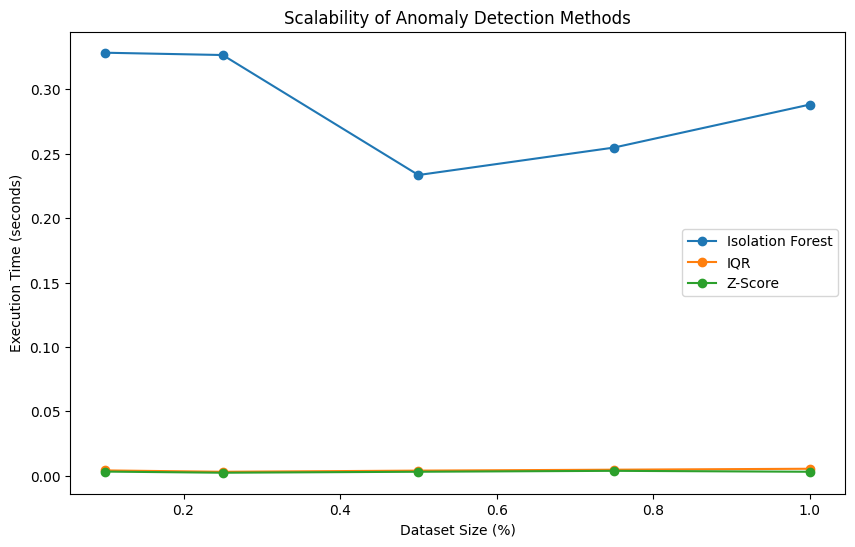

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for method, method_times in times.items():
    plt.plot(sample_sizes, method_times, label=method, marker='o')

plt.xlabel("Dataset Size (%)")
plt.ylabel("Execution Time (seconds)")
plt.title("Scalability of Anomaly Detection Methods")
plt.legend()
plt.show()
